In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/feedback-prize-2021/train/'):
    filenum = 1
    for filename in filenames:
        f = open(os.path.join(dirname, filename),'r')
        doc = f.read()
        doc_id = filename[:filename.find('.txt')]
        doc_len = len(doc.split())
        doc_df = pd.DataFrame([[doc_id,doc,doc_len]], columns=['id','text','word_num'])
        if filenum == 1:
            docs = doc_df
        else:
            docs = docs.append(doc_df, ignore_index=True)
        filenum += 1
        f.close()

csv_dirname = '/kaggle/input/feedback-prize-2021/'
csv_filename = 'train.csv'        
df = pd.read_csv(os.path.join(csv_dirname, csv_filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

#stokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
labels = df.discourse_type.unique()
labels_map = {'NO_TAG':0, 'Lead':1, 'Position':2, 'Evidence':3, 'Claim':4, 'Concluding Statement':5,
             'Counterclaim':6, 'Rebuttal':7}
iob_labels = dict()
index = 0
for label in labels_map:
    if label != 'NO_TAG':
        iob_label = 'B-'+label
        index +=1
        iob_labels[iob_label] = index
        iob_label = 'I-'+label
        index +=1
        iob_labels[iob_label] = index
    else:
        iob_labels[label] = index

In [ ]:
!pip install distilbert-punctuator

In [ ]:
#from dbpunctuator.inference import Inference, InferenceArguments
#from dbpunctuator.utils import DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP
#args = InferenceArguments(
#        model_name_or_path="Qishuai/distilbert_punctuator_en",
#        tokenizer_name="Qishuai/distilbert_punctuator_en",
#        tag2punctuator=DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP
#    )
#punctuator_model = Inference(inference_args=args, 
#                             verbose=False)

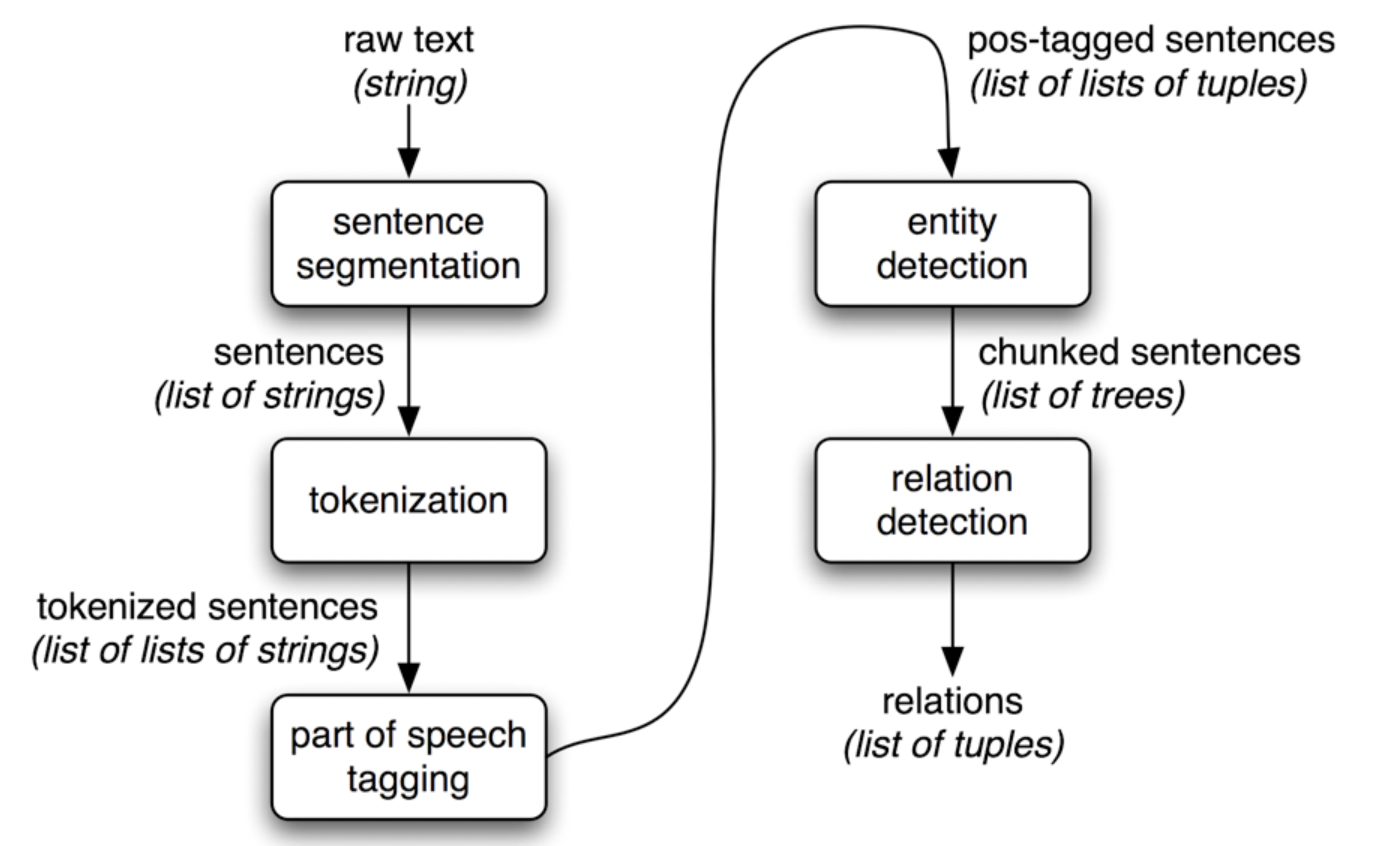

## Sentences segmentation

In [ ]:
def get_sentences(txt, txt_id):
    sentences = sent_tokenize(txt)
    sent_len = []
    for sentence in sentences:
        sent_len.append(len(sentence.split()))
    df_sent = pd.DataFrame(sentences, columns=['sentences'])
    df_sent['sentence_len'] = sent_len
    df_sent['id'] = txt_id
    return df_sent

**The text need a correction of punctuation to get sentences rigth. To fix I'm using the distilbert-punctuator**

As the text > 512 tokens longs is an issue, for a moment I'll remove outliers by word_len from dataset. Later I'll find a solution for remaining.

In [ ]:
docs['word_num'].describe()

In [ ]:
f, ax = plt.subplots(figsize=(10,2))
docs.boxplot(column='word_num', vert=False)
plt.show

In [ ]:
initial_docs = docs # keeping initial dataset for futur investigation
docs  = docs[docs.word_num <= 800]
docs.info()

In [ ]:
kept_ids = docs.id.unique()

In [ ]:
initial_df = df
df = df[df.id.isin(kept_ids)]
df.info()

In [ ]:
initial_df.head()

In [ ]:
sns.countplot(df['discourse_type'], palette='gist_rainbow',)
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.discourse_type.value_counts()

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
for index, row in docs.iterrows():
    raw_txt = row['text']
    cleaned_txt = BeautifulSoup(raw_txt, "lxml").text
    #txt_edit = punctuator_model.punctuation([cleaned_txt])[0]
    #txt = txt_edit[0]
    txt = cleaned_txt
    docs.at[index,'processed_text'] = txt
    txt_id = row['id']
    df_sent = get_sentences(txt, txt_id)
    prev = -1
    for i,r in df_sent.iterrows():
        df_sent.at[i,'word_start'] = prev+1
        df_sent.at[i,'word_end'] = prev + r['sentence_len']
        prev = df_sent.loc[i,'word_end']
        
    if index==0:
        df_sentences = df_sent
    else:
        df_sentences = df_sentences.append(df_sent, ignore_index=True)
    
    

In [ ]:
df_sentences.info()

In [ ]:
df_sentences.head()

In [ ]:
df_sentences.sentence_len.describe()

In [ ]:
f, ax = plt.subplots(figsize=(10,2))
df_sentences.boxplot(column='sentence_len', vert=False)
plt.show

In [ ]:
df_sentences = df_sentences[df_sentences.sentence_len <= 25]

In [ ]:
df_sentences = df_sentences[df_sentences.sentence_len > 2]

In [ ]:
df_sentences.info()

## Getting label for each sentence (by comparing "start word" of sentence and "end word" of sentence with predictionstring of train.csv

There are 3 cases of labelling Sentence vs Discours vs Label (discours_type)
1. Sentence 1 -> Discours 1 -> Label 1

   Sentence 2 -> Discours 2 -> Label 2
   
2. Sentence 1 -> Discours 1 -> Label 1

   Sentence 2 -> Discours 1 -> Label 1 
   
3. Sentence 1 -> Discours 1 -> Label 1

   Sentence 1 -> Discours 2 -> Label 2
   
   
 Cases 1 and 2 are quite straightforward to label. Case 3 is less obvious. For the first version I just keep the label for the first part of sentence. To be improved later. 
 
 First step is to assess the case for each sentence. 
 For this purpose: get discours_start and discours_end expressed in words (first and last word indexes from predictionstring)

In [ ]:
df['discours_start_word'] = df['predictionstring'].apply(lambda l: float(l.split()[0]))
df['discours_end_word'] = df['predictionstring'].apply(lambda l: float(l.split()[-1]))

In [ ]:
df.head()

In [ ]:
def label_sentences(s, tags):
    for index, row in s.iterrows():
        sentence_start = row['word_start']
        sentence_end = row['word_end']
        # get all lignes corresponding to the sentence from tags
        # if only on line is returned. - copy label
        # if more than one - copy each slice
        tags = tags.reset_index(drop=True)
        left = tags[tags.discours_start_word >= sentence_start]
        sentences_tags = left[left.discours_end_word <= sentence_end]
    
        returned_num = sentences_tags.shape[0]
        #print(sentences_tags.shape[0])
        if returned_num == 1:
            s.at[index,'label'] = sentences_tags.iloc[0,5]
            s.at[index,'discourse_text'] = sentences_tags.iloc[0,4]
    
        if returned_num == 0:
            case2 = tags[tags.discours_start_word <= sentence_start]
            discourse = case2[case2.discours_end_word >= sentence_end]
            if discourse.shape[0] >0:
                s.at[index,'label'] = discourse.iloc[0,5]
                s.at[index,'discourse_text'] = discourse.iloc[0,4]
    
        if returned_num > 1:
            # check if sentence is fully covered by discourses
            #min_slice_start = sentences_tags.discours_start_word.min()
            #max_slice_end = sentences_tags.discours_end_word.max()
            #if sentence_start == min_slice_start and sentence_end == max_slice_end:
            
            s.at[index,'label'] = sentences_tags.iloc[0,5]
            s.at[index,'discourse_text'] = sentences_tags.iloc[0,4]
            
    
    return s
        #s.at[index,'label'] = "that's yet to be done"
        #s.at[index,'discourse_text'] = "that's yet to be done"
        
    #case 1: one sentence - one discours - one label
    #case 2: a sentence is a part of discours, more than one sentence share the same label 
    #case 3: a sentences contains more than one discours/label
    

In [ ]:
first = True
for txt_id in kept_ids:
    s = df_sentences[df_sentences.id == txt_id]
    tags = df[df.id == txt_id]
    labelled = label_sentences(s, tags)
    # for each sentence in sentences map all its label and corresponding discours text
    if first:
        data = labelled
        first = False
    else:
        data = data.append(labelled, ignore_index=True)
    

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data = data.fillna('NO_TAG')

In [ ]:
data.info()

In [ ]:
import json

output_path = '/kaggle/working/'
output_file = 'labeled_sentences.json'
dfj = data.to_json(orient='index')

with open(os.path.join(output_path, output_file), 'w') as f:
    json.dump(dfj, f)

## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(data.id.values, 
#                                                    data.label.values, 
#                                                    test_size=0.2, 
#                                                    random_state=35)

In [ ]:
#data['data_type'] = ['not_set']*data.shape[0]
#data.loc[data.id.isin(X_train.tolist()), 'data_type'] = 'train'
#data.loc[data.id.isin(X_test.tolist()), 'data_type'] = 'test'

In [ ]:
data.head()

In [ ]:
data = data[['sentences','id','label']]

In [ ]:
data['lbl'] = data['label'].apply(lambda x: labels_map[x])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['sentences']], 
                                                    data[['lbl']], 
                                                    test_size=0.2, 
                                                    random_state=35)

In [ ]:
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(data.index.values, 
                                                                    data.label.values, 
                                                                    test_size=0.2, 
                                                                    random_state=35)

In [ ]:
data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train_ind, 'data_type'] = 'train'
data.loc[X_test_ind, 'data_type'] = 'test'

data.groupby(['label', 'data_type']).count()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer()
tfidf = TfidfVectorizer()

In [ ]:
X_train.head()

In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score

## Encoding with word2vec

In [ ]:
import multiprocessing
import gensim
from sklearn import preprocessing

In [ ]:
# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 200
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-1

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [ ]:
def format_gensim(txt):
    #tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = txt.split()
    return tokens
posts = data['sentences'].apply(lambda x: format_gensim(x))

In [ ]:
posts2vec = gensim.models.word2vec.Word2Vec(
    workers=num_workers,
    min_count=min_word_count,
    window=context_size
)

posts2vec.build_vocab(posts)

In [ ]:
def postVector(row):
    vector_sum = 0
    sentence = row.split()
    #print(sentence)
    for word in sentence:
        vector_sum = vector_sum + posts2vec.wv[word]
    vector_sum = vector_sum.reshape(1,-1)
    normalised_vector_sum = preprocessing.normalize(vector_sum)
    return normalised_vector_sum

In [ ]:
def transform_text(in_data):
    data = in_data.copy()
    data['vector'] = data['sentences'].apply(lambda txt: postVector(txt))
    data = data.drop(columns=['sentences'])
    return data

In [ ]:
x_train_vectors = transform_text(X_train)
train_vectors = []
for vector in x_train_vectors['vector']:
    train_vectors.append(vector)
x_train_w2v = np.array(train_vectors).reshape((x_train_vectors.shape[0], 100))


In [ ]:
x_test_vectors = transform_text(X_test)
test_vectors = []
for vector in x_test_vectors['vector']:
    test_vectors.append(vector)
x_test_w2v = np.array(test_vectors).reshape((x_test_vectors.shape[0], 100))

## Doc2vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
dt = data.copy()
texts = dt.to_dict('records')    #### DATAFRAME TO DICTIONARY FORMAT .
documents = [TaggedDocument(text['sentences'].split(), [text['label']])  for text in texts]
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=11,alpha=0.025, min_alpha=0.025, epochs=20)
model.build_vocab(documents)
model.train(documents, epochs=model.epochs, total_examples=model.corpus_count)

X_train['doc_vector'] = X_train['sentences'].apply(lambda x: model.infer_vector(x.split()))
X_test['doc_vector'] = X_test['sentences'].apply(lambda x: model.infer_vector(x.split()))

In [ ]:
x_train_vectors = X_train.drop(columns=['sentences'])
x_test_vectors = X_test.drop(columns=['sentences'])

In [ ]:
x_train_vectors.head()

In [ ]:
train_vectors = []
for vector in x_train_vectors['doc_vector']:
    train_vectors.append(vector)
x_train_d2v = np.array(train_vectors).reshape((x_train_vectors.shape[0], 100))


test_vectors = []
for vector in x_test_vectors['doc_vector']:
    test_vectors.append(vector)
x_test_d2v = np.array(test_vectors).reshape((x_test_vectors.shape[0], 100))



## Try the models

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
alpha_lst = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]

In [ ]:
micro_f1_scores = []
for alpha_ in alpha_lst:
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=alpha_, penalty='l1'))
    cv_scores = cross_val_score(classifier,x_train_d2v, y_train, cv=3, scoring='f1_micro')
    micro_f1_scores.append(cv_scores.mean())

In [ ]:
# plot alpha vs micro f1 score
plt.plot(alpha_lst,micro_f1_scores)
for i in range (0,len(alpha_lst)):
    plt.annotate('%s' %alpha_lst[i], xy=(alpha_lst[i],micro_f1_scores[i]))
plt.show()
best_alpha = alpha_lst[np.argmax(micro_f1_scores)]
print('\nThe best value of alpha is %s.' %best_alpha)

In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=best_alpha, penalty='l1'))

In [ ]:
y_test.shape

In [ ]:
x_test_d2v.shape

In [ ]:
#classifier.fit(x_train_w2v, y_train)
#y_pred_w2v = classifier.predict(x_test_w2v)

classifier.fit(x_train_d2v, y_train)
y_pred_d2v = classifier.predict(x_test_d2v)

precision = precision_score(y_test, y_pred_d2v, average='macro')
recall = recall_score(y_test, y_pred_d2v, average='macro')
f1 = f1_score(y_test, y_pred_d2v, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_test, y_pred_d2v),annot=True)

In [ ]:
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC

clf = OutputCodeClassifier(LinearSVC(random_state=0),
                           code_size=2, random_state=0)
#y_pred_w2v = clf.fit(x_train_w2v, y_train).predict(x_test_w2v)
y_pred_d2v = clf.fit(x_train_d2v, y_train).predict(x_test_d2v)

In [ ]:
precision = precision_score(y_test, y_pred_d2v, average='macro')
recall = recall_score(y_test, y_pred_d2v, average='macro')
f1 = f1_score(y_test, y_pred_d2v, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))



In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_test, y_pred_d2v),annot=True)

## Trying BERT 

In [ ]:
data.head()

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from tqdm.notebook import tqdm

In [ ]:
BERTtokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
encoded_data_train = BERTtokenizer.batch_encode_plus(
    data[data.data_type=='train'].sentences.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = BERTtokenizer.batch_encode_plus(
    data[data.data_type=='test'].sentences.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].lbl.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='test'].lbl.values)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
from transformers import BertForSequenceClassification

BERTmodel = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(labels_map),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
optimizer = AdamW(BERTmodel.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

In [ ]:
def evaluate(dataloader_val):

    BERTmodel.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = BERTmodel(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BERTmodel.to(device)

print(device)

In [ ]:
#for epoch in tqdm(range(1, epochs+1)):
    
#    BERTmodel.train()
    
#    loss_train_total = 0

#    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
#    for batch in progress_bar:

#        BERTmodel.zero_grad()
        
#        batch = tuple(b.to(device) for b in batch)
        
#        inputs = {'input_ids':      batch[0],
#                  'attention_mask': batch[1],
#                  'labels':         batch[2],
#                 }       

#        outputs = BERTmodel(**inputs)
        
#        loss = outputs[0]
#        loss_train_total += loss.item()
#        loss.backward()

 #       torch.nn.utils.clip_grad_norm_(BERTmodel.parameters(), 1.0)

 #       optimizer.step()
 #       scheduler.step()
        
 #       progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
 #   torch.save(BERTmodel.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
 #   tqdm.write(f'\nEpoch {epoch}')
    
 #   loss_train_avg = loss_train_total/len(dataloader_train)            
 #   tqdm.write(f'Training loss: {loss_train_avg}')
    
 #   val_loss, predictions, true_vals = evaluate(dataloader_validation)
 #   val_f1 = f1_score_func(predictions, true_vals)
 #   tqdm.write(f'Validation loss: {val_loss}')
 #   tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [ ]:
#plt.figure(figsize=(15,15))
#sns.heatmap(confusion_matrix(true_vals, predictions),annot=True)

## Create output CSV

### Read test folder
### Segment to sentences
### Vectorize each sentence with doc2vec
### Predict label for each sentence
### Encode each sentence with corresponding words' indexes
### Group by id, label concatenate sentence_codes

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input/feedback-prize-2021/test/'):
    filenum = 1
    for filename in filenames:
        f = open(os.path.join(dirname, filename),'r')
        doc = f.read()
        doc_id = filename[:filename.find('.txt')]
        doc_len = len(doc.split())
        doc_df = pd.DataFrame([[doc_id,doc,doc_len]], columns=['id','text','word_num'])
        if filenum == 1:
            test_df = doc_df
        else:
            test_df = test_df.append(doc_df, ignore_index=True)
        filenum += 1
        f.close()

In [ ]:
test_df.info()

In [ ]:
test_df

In [ ]:
for index, row in test_df.iterrows():
    raw_txt = row['text']
    cleaned_txt = BeautifulSoup(raw_txt, "lxml").text
    txt_edit = punctuator_model.punctuation([cleaned_txt])[0]
    txt = txt_edit[0]
    docs.at[index,'processed_text'] = txt
    txt_id = row['id']
    df_sent = get_sentences(txt, txt_id)
    prev = -1
    for i,r in df_sent.iterrows():
        df_sent.at[i,'word_start'] = prev+1
        df_sent.at[i,'word_end'] = prev + r['sentence_len']
        prev = df_sent.loc[i,'word_end']
        
    if index==0:
        df_test_sentences = df_sent
    else:
        df_test_sentences = df_test_sentences.append(df_sent, ignore_index=True)

In [ ]:
df_test_sentences.info()

In [ ]:
df_test_sentences['sentence_len'].describe()

In [ ]:
df_test_sentences['doc_vector'] = df_test_sentences['sentences'].apply(lambda x: model.infer_vector(x.split()))

test_vectors = []
for vector in df_test_sentences['doc_vector']:
    test_vectors.append(vector)
test_d2v = np.array(test_vectors).reshape((df_test_sentences.shape[0], 100))
pred_d2v = classifier.predict(test_d2v)


In [ ]:
pred_d2v

In [ ]:
df_test_sentences['prediction_num'] = pred_d2v.tolist()

In [ ]:
df_test_sentences.head()

In [ ]:
def get_class(x):
    return list(labels_map.keys())[list(labels_map.values()).index(x)]

In [ ]:
df_test_sentences['class'] = df_test_sentences['prediction_num'].apply(lambda x: get_class(x))

In [ ]:
def get_words(start, end):
    words=[str(x) for x in list(range(start, end+1))]
    s=' '.join(words)
    return s

In [ ]:
df_test_sentences_copy = df_test_sentences

In [ ]:
df_test_sentences['predictionstring'] = df_test_sentences.apply(lambda r: get_words(int(r['word_start']),int(r['word_end'])), axis=1)

In [ ]:
df_test_sentences.head()

In [ ]:
df_test_sentences = df_test_sentences[df_test_sentences.prediction_num != 0]

In [ ]:
df_test_sentences.info()

In [ ]:
for_submission = df_test_sentences[['id','class','predictionstring']]

In [ ]:
for_submission

In [ ]:
for_submission.to_csv('submission.csv', index=False)